In [126]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models import CoherenceModel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# load all metadata

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gorka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [127]:
#Cargamos los datos
data = pd.read_csv('justice.csv')
x_train = data['facts']
y_train1 = data['first_party_winner']
y_train2 = data['issue_area']

In [128]:
#Elimina signos de puntuacion y todo a minusculas
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(x_train))

In [129]:
#Eliminamos las stop words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

In [130]:
lem = WordNetLemmatizer()
ps = PorterStemmer()

In [131]:
#Lematizamos
def lemmatization(texts):
    texts_out = []
    for text in texts:
        lemText = []
        for sent in text:
            stemmed = ps.stem(sent)
            lemText.append(lem.lemmatize(stemmed))
        texts_out.append(lemText)
    return texts_out

data_lemmatized = lemmatization(data_words_nostops)

In [132]:
#Topic modeling
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
#lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=20, random_state=100, update_every=1, chunksize=100, passes=20, alpha='auto',per_word_topics=True)
#print(f"TOPICOS --> {lda.print_topics()}")

lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=20, random_state=100, passes=50, eval_every=None)
count = 0
topics=[]
for i in lda_model.print_topics():
    print("Topic:", count, i)
    topics.append(i)
    count += 1

Topic: 0 (0, '0.035*"patent" + 0.020*"use" + 0.019*"court" + 0.017*"infring" + 0.012*"appeal" + 0.010*"district" + 0.010*"feder" + 0.009*"product" + 0.009*"copyright" + 0.009*"inc"')
Topic: 1 (1, '0.043*"m" + 0.027*"st" + 0.023*"naacp" + 0.017*"basic" + 0.017*"dr" + 0.015*"levin" + 0.010*"war" + 0.009*"zenith" + 0.009*"sprint" + 0.009*"easement"')
Topic: 2 (2, '0.085*"court" + 0.031*"appeal" + 0.028*"state" + 0.028*"petit" + 0.024*"feder" + 0.023*"file" + 0.022*"district" + 0.020*"counsel" + 0.020*"habea" + 0.018*"deni"')
Topic: 3 (3, '0.046*"court" + 0.023*"arbitr" + 0.018*"district" + 0.018*"claim" + 0.017*"carolina" + 0.016*"state" + 0.016*"north" + 0.015*"feder" + 0.014*"agreement" + 0.013*"law"')
Topic: 4 (4, '0.022*"state" + 0.018*"land" + 0.016*"act" + 0.013*"tribe" + 0.011*"court" + 0.010*"servic" + 0.010*"regul" + 0.009*"unit" + 0.009*"nation" + 0.009*"feder"')
Topic: 5 (5, '0.043*"sentenc" + 0.043*"juri" + 0.033*"death" + 0.027*"murder" + 0.027*"trial" + 0.017*"convict" + 0.0

In [133]:
#Hay que cambiar el n_topics por el numero de topics del LDA
n_topics = 30
vectorized = []
count = 0
#Recorrer los documentos
for i in lda_model[corpus]:
    #Inicializar index como lista de ceros, de longitud 'n_topics'
    index = [0]*n_topics
    #Recorrer cada palabra de cada documento
    for n in i:
        #En index[8] guardamos la informacion del tópico 8
        index[n[0]] = n[1]
    vectorized.append(index)
vectorized = pd.DataFrame(vectorized)
#Filas documentos (facts)
#Columnas topics
print(vectorized)

            0    1         2         3         4         5         6   \
0     0.000000  0.0  0.000000  0.000000  0.000000  0.118256  0.000000   
1     0.000000  0.0  0.000000  0.000000  0.131371  0.000000  0.000000   
2     0.000000  0.0  0.072559  0.000000  0.000000  0.000000  0.000000   
3     0.000000  0.0  0.000000  0.000000  0.000000  0.040615  0.000000   
4     0.182056  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...  ...       ...       ...       ...       ...       ...   
3298  0.000000  0.0  0.049182  0.000000  0.000000  0.000000  0.000000   
3299  0.087502  0.0  0.087258  0.027243  0.000000  0.000000  0.000000   
3300  0.000000  0.0  0.000000  0.021977  0.148934  0.000000  0.010125   
3301  0.000000  0.0  0.000000  0.179831  0.000000  0.000000  0.303487   
3302  0.086962  0.0  0.000000  0.115084  0.266418  0.000000  0.000000   

            7         8         9   ...  20  21  22  23  24  25  26  27  28  \
0     0.000000  0.124620  0.053426  ...   0 

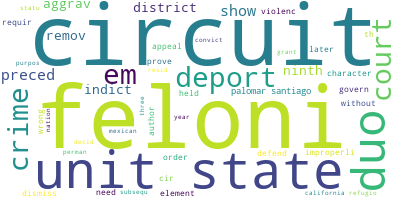

In [134]:
#Word cloud de documento 3298
from wordcloud import WordCloud

nDocumento = 3298
string = ','.join(data_lemmatized[nDocumento])

wordcloud = WordCloud(background_color="white", max_words=len(data_lemmatized[0]), contour_width=3, contour_color='steelblue')
wordcloud.generate(string)
wordcloud.to_image()

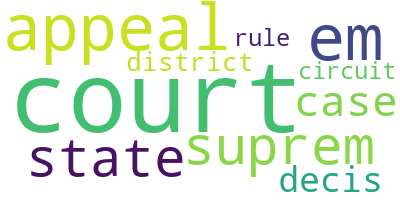

In [135]:
# WordCloud del topico 15
l = topics[15][1]

l = l.split("+")

lista =[]
for x in l:
    numero, palabra = x.split('*')
    palabra = palabra.split('"')[1]
    i=0
    while i < float(numero)*100:
        lista.append(palabra)
        i+=1
lista = ','.join(lista)

wordcloud.generate(lista)
wordcloud.to_image()


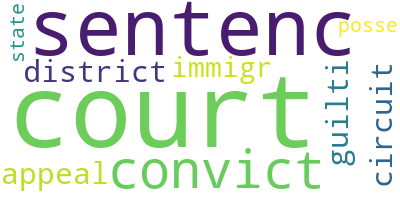

In [136]:
# WordCloud del topico 16
l = topics[16][1]

l = l.split("+")

lista =[]
for x in l:
    numero, palabra = x.split('*')
    palabra = palabra.split('"')[1]
    i=0
    while i < float(numero)*100:
        lista.append(palabra)
        i+=1
lista = ','.join(lista)

wordcloud.generate(lista)
wordcloud.to_image()


In [137]:
#Comparar dimensiones antes y después de hacer el pca
from sklearn.decomposition import  PCA

print("Before:", vectorized.shape)
pca = PCA(n_components='mle', svd_solver='full')
#pca = PCA(n_components=2)
pca.fit(vectorized)
labels_PCA= pca.transform(vectorized)
print("After:", labels_PCA.shape)

Before: (3303, 30)
After: (3303, 20)


In [138]:
#Distancia euclídea
import math
import numpy as np
def getDist(clust1, clust2):
    dist = 0
    #Sumatorio de distancias euclideas
    for i in range(len(clust1)):
        #Calcular la distancia euclídea de cada i
        dist += math.sqrt((clust1[i] - clust2[i])**2)
    return dist

In [139]:
#Generar la matriz con las distancias entre cada cluster
def getDistances(clusters):
    distances = []
    for clust1 in range(len(clusters)):
        #Convertir a numpy
        dist_clust1 = [np.NAN] * (clust1+1)
        for clust2 in [t for t in range(len(clusters)) if t > clust1]:
            dist_clust1.append(getDist(clusters[clust1], clusters[clust2]))
        distances.append(np.array(dist_clust1))
    distances = np.array(distances)
    return distances

In [140]:
#Agrupa la fila y columna de la matriz de distancias, con la menor distancia
data = labels_PCA.copy()
distances = getDistances(data)
k_clusters = [0,0,[[i] for i in range(len(data))]]

tree = [[],[]]
tree_aux = [i for i in range(len(data))]
list_of_clusters = []
list_of_clusters.append([k_clusters[0],k_clusters[1],k_clusters[2].copy()])
it = 0
n_inst = len(data)

print("Starting")

while len(distances) > 1:
    ind1,ind2 = np.unravel_index(np.nanargmin(distances), distances.shape)
    min_dist = np.nanmin(distances)
    delete = max(ind1,ind2)
    replace = min(ind1,ind2)
    for i in [t for t in range(len(distances)) if t != ind1 and t != ind2]:
        distance = np.nanmax([distances[ind1][i],distances[ind2][i],distances[i][ind1],distances[i][ind2]])
        if replace < i:
            distances[replace][i] = distance
        else:
            distances[i][replace] = distance

    distances = np.delete(distances, delete,1)
    distances = np.delete(distances, delete,0)

    tree[0].append([tree_aux[replace],tree_aux[delete]])
    tree[1].append(min_dist)
    tree_aux[replace] = it + n_inst
    tree_aux.remove(tree_aux[delete])

    k_clusters[0] = it
    k_clusters[1] = min_dist
    k_clusters[2][replace] = k_clusters[2][replace]+k_clusters[2][delete]
    k_clusters[2].remove(k_clusters[2][delete])
    it += 1

    list_of_clusters.append([k_clusters[0],k_clusters[1],k_clusters[2].copy()])

print("End")

Starting
End


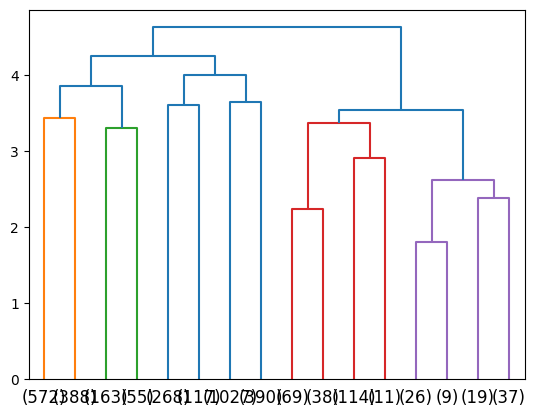

In [152]:
import numpy as np

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(tree, labels ,mode , p, threshold):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(len(tree[0]))
    n_samples = len(labels)
    for i, merge in enumerate(tree[0]):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [tree[0], tree[1], counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, truncate_mode=mode, p=p , color_threshold=threshold)


#mode : "lastp" p numero de nodos hoja, "level" p profundidad del dendograma.
#threshold : la linea que separa los clusters.
plot_dendrogram(tree,labels_PCA,mode ="level", p=3, threshold=3.5)

In [142]:
def get_nClusters(list_clusters, k):
    n_inst = len(list_clusters[0][2])
    for clusters in list_clusters:
        if len(clusters[2]) == k:
            kClusters = [0] * n_inst
            i = 0
            for clust in clusters[2]:
                for c in clust:
                    kClusters[c] = i
                i += 1
            return kClusters
    return []


k_clusters = get_nClusters(list_of_clusters,2)

In [143]:
def get_distClusters(list_clusters, d):
    n_inst = len(list_clusters[0][2])
    clusters_aux = list_clusters[0]
    for clusters in list_clusters:
        if clusters[1] > d:
            distClusters = [0] * n_inst
            i = 0
            for clust in clusters_aux[2]:
                for c in clust:
                    distClusters[c] = i
                i += 1
            return distClusters
        clusters_aux = clusters
    return []


dist_clusters = get_distClusters(list_of_clusters,1)

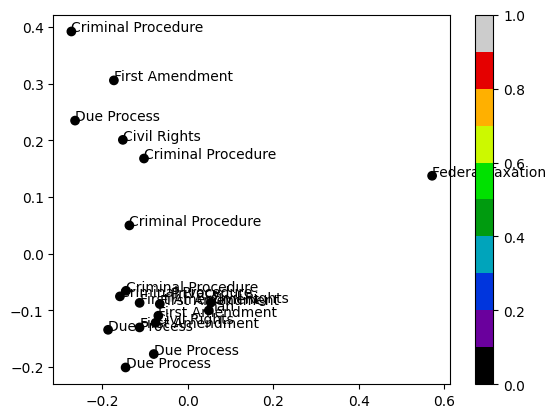

In [144]:
import matplotlib.pyplot as plt
samples = 20

# Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
# Color del punto: cluster
sc = plt.scatter(labels_PCA[:samples,0],labels_PCA[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', 10),c=k_clusters[:samples])
plt.colorbar()
# Etiqueta numérica: clase
for i in range(samples):
    plt.text(labels_PCA[i,0],labels_PCA[i,1], y_train2[i])

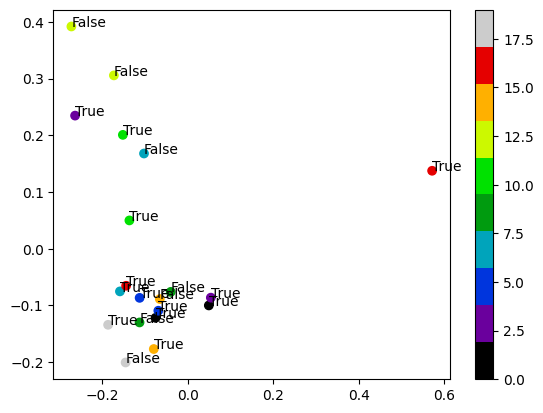

In [145]:
import matplotlib.pyplot as plt
samples = 20

# Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
# Color del punto: cluster
sc = plt.scatter(labels_PCA[:samples,0],labels_PCA[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', 10),c=dist_clusters[:samples])
plt.colorbar()
# Etiqueta numérica: clase
for i in range(samples):
    plt.text(labels_PCA[i,0],labels_PCA[i,1], y_train1[i])

In [146]:
#Cosas por hacer
#Poder meter un documento en el clúster, antes de meterlo asignarle los tópicos y hacerle pca
#Faltan las metricas de evaluación de calidad.

In [147]:
#Metricas de evaluación de calidad 

In [148]:
#Calcular los centroides de los clusters 

In [149]:
#Añadir una nueva instancia

In [150]:
#Clasificar la nueva instancia en un cluster

In [151]:
#Decir a qué cluser se le ha asignado 